In [323]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import matplotlib.pyplot as plt

In [324]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [325]:
np.random.seed(0)
torch.manual_seed(0)

In [326]:
def get_state(curr_state, drift, days, action):
    """
    Calculate the next state based on the current state and drift.
    """
    if action==1:
        return 2*drift*days+1
    delta = np.random.randint(-drift, drift, dtype=int)
    return max(0, min(curr_state + delta, 2 * days * drift))

In [327]:
def get_reward(curr_state, action, days, drift, start_price, strike_price):
    """
    Calculate the reward based on the current state and action.
    """
    if action == 0:
        return 0
    else:
        return curr_state - days * drift + start_price - strike_price

In [328]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(PolicyNetwork, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.input_activation = nn.ReLU()

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            layer = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(layer)
            self.hidden_layers.append(nn.ReLU())

        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.output_activation = nn.Softmax(dim=-1)

    def forward(self, state):
        x = self.input_layer(state)
        x = self.input_activation(x)
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x

In [329]:
# Define the input and output sizes
input_size = 2 # Size of your state representation
output_size = 2  # Number of actions (exercise or not exercise)

In [330]:
hidden_size = 64
num_hidden_layers = 4
policy_network = PolicyNetwork(input_size, hidden_size, output_size, num_hidden_layers)

# Define the optimizer
optimizer = optim.Adam(policy_network.parameters(), lr=1e-5)

In [331]:
T = 5  # Number of time steps
drift = 5
start_price = 500
strike_price = 505

In [332]:
start_states=[]
loss_arr=[]
reward_arr=[]

In [344]:
def print_policy(model, drift, start_price, strike_price, T):
    policy = []  # Dictionary to store policy for each time-price pair

    for time in range(T):
        time_policy = []  # Policy for current time
        for price in range(2 * T * drift + 1):
            # Move input data to GPU
            state = torch.tensor([price, time], dtype=torch.float32).to(device)
            action_probs = model(state.unsqueeze(0))

            time_policy.append(action_probs.argmax().item())
        policy.append(time_policy)

    # Print policy for each time-price pair
    for time, price_policy in enumerate(policy):
        print(f"Time: {time + 1}")
        print(price_policy)
    
    optimal_policy=[]
    for time,price_policy in enumerate(policy):
        for i,price in enumerate(price_policy):
            if(price==1):
                optimal_policy.append(i-T*drift+start_price)
                break
    
    return optimal_policy
# Call the function to print the policy

In [334]:
def train_reinforce(num_episodes, days=T, drift=drift, start_price=500, strike_price=505, df=0.99):
    for episode in range(num_episodes):
        episode_rewards = []
        baseline=0
        log_probs = []
        curr_state = np.random.randint(0,2*days*drift+1)
        time = np.random.randint(0,days)
        start_states.append((curr_state, time))
        done = False
        while not done:
            state_tensor = torch.from_numpy(
                np.array([curr_state, time], dtype=np.float32)
            )
            action_probs = policy_network(state_tensor.unsqueeze(0))  
            # print(action_probs)
            if np.random.uniform() < action_probs[0][0].item():
                action = 0
            else:
                action = 1

            log_probs.append(torch.log(action_probs[0][action]))

            next_state = get_state(curr_state, drift, days, action)
            reward = get_reward(
                curr_state, action, days, drift, start_price, strike_price
            )
            episode_rewards.append(reward)

            curr_state = next_state
            time += 1

            if time == days or action == 1:
                done = True

        G = 0
        for t in reversed(range(len(episode_rewards))):
            G = G * df + episode_rewards[t]
        reward_arr.append(G)

        log_probs = torch.stack(log_probs)
        policy_loss = -log_probs * (G-baseline)
        baseline = (baseline*episode+G)/(episode+1)
        optimizer.zero_grad()
        policy_loss = policy_loss.sum()
        # print("Loss : ",policy_loss)
        loss_arr.append(policy_loss.item())
        policy_loss.backward()
        optimizer.step()

        state = torch.tensor([2 * T * drift, T - 1], dtype=torch.float32).to(device)
        action_probs = policy_network(state.unsqueeze(0))

        if (episode+1) % 10000 == 0:
            print(f"Episode: {episode + 1}")
        # if(episode%10000) ==0:
        #     print_policy(policy_network, drift, start_price, strike_price, T)

In [335]:
train_reinforce(num_episodes=230000)

Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000
Episode: 50000
Episode: 60000
Episode: 70000
Episode: 80000
Episode: 90000
Episode: 100000
Episode: 110000
Episode: 120000
Episode: 130000
Episode: 140000
Episode: 150000
Episode: 160000
Episode: 170000
Episode: 180000
Episode: 190000
Episode: 200000
Episode: 210000
Episode: 220000
Episode: 230000


In [347]:
optimal_policy=print_policy(policy_network, drift, start_price, strike_price, T)

Time: 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Time: 2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Time: 3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Time: 4
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Time: 5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [348]:
for day, price in enumerate(optimal_policy):
    print(f"Day {day+1} : Price {price}")

Day 1 : Price 507
Day 2 : Price 507
Day 3 : Price 506
Day 4 : Price 505
Day 5 : Price 505


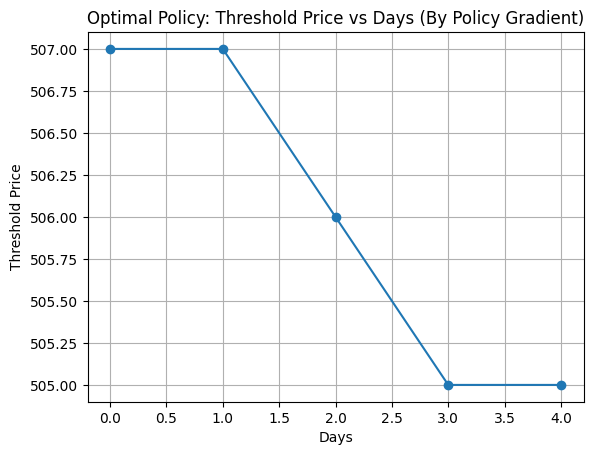

In [357]:
plt.plot(optimal_policy, marker='o')  # Plotting every 100th value
plt.title('Optimal Policy: Threshold Price vs Days (By Policy Gradient)')
plt.xlabel('Days')
plt.ylabel('Threshold Price')
plt.grid(True)  # Add grid
plt.show()

In [350]:
for i in range(len(loss_arr)):
    loss_arr[i] = abs(loss_arr[i])

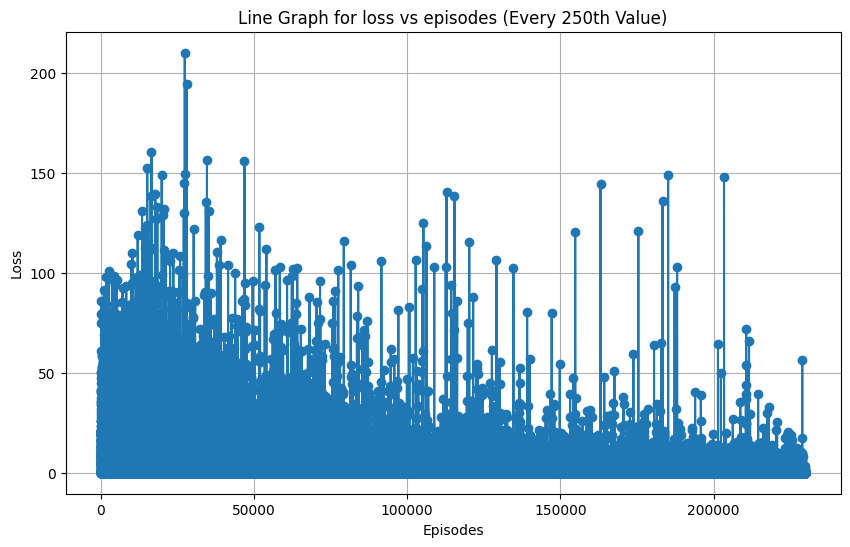

In [351]:
plt.figure(figsize=(10,6))
plt.plot(loss_arr[::1], marker='o')  # Plotting every 100th value
plt.title('Line Graph for loss vs episodes (Every 250th Value)')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.grid(True)  # Add grid
plt.show()

In [352]:
def transition_probability(drift):
    """
    Calculates the transition probability for the given drift.
    """
    return 1 / (2 * drift + 1)

def get_state(drift):
    """
    Generates a random state within the given drift range.
    """
    return np.random.randint(-drift, drift, dtype=int) 

def value_iteration(gamma=0.99):
    """
    Performs value iteration to find the optimal policy.
    """
    start_price, strike_price = 500, 505
    drift = 5  # Change in stock price on each day
    T = 5  # Number of days till expiry

    V = np.zeros((2 * T * drift + 1, T))
    policy = np.zeros((T, 2 * T * drift + 1))

    # Initialize the value function and policy
    for state in range(2 * T * drift + 1):
        V[state][T - 1] = max(0, state - (strike_price - start_price) - T * drift)
        if V[state][T - 1] > 0:
            policy[T - 1][state] = 1

    # Perform value iteration
    for t in reversed(range(T - 1)):
        Q = np.zeros((2 * T * drift + 1, 2))
        for state in range(2 * T * drift + 1):
            for action in [0, 1]:
                new_value = 0.0
                if action == 0:
                    reward = 0
                    for next_state in range(state - drift, state + drift):
                        if 0 <= next_state <= 2 * T * drift:
                            new_value += transition_probability(drift) * (reward + gamma * V[next_state][t + 1])
                else:
                    reward = state - (strike_price - start_price) - T * drift
                    new_value = reward
                Q[state][action] = new_value
            V[state][t] = max(Q[state])
            # Update policy based on Q values
            if Q[state][0] >= Q[state][1]:
                policy[t][state] = 0
            else:
                policy[t][state] = 1
    optimal = []
    for t in range(T):
        for i in reversed(range(2 * T * drift + 1)):
            if policy[t][i] == 0:
                optimal.append(i - T * drift + start_price)
                break
    plt.plot(optimal)
    plt.title('Optimal Policy: Threshold Price vs Days (By Value Iteration)')
    plt.xlabel('Days')
    plt.ylabel('Threshold Price')
    plt.grid(True)  # Add grid
    plt.show()
    return V

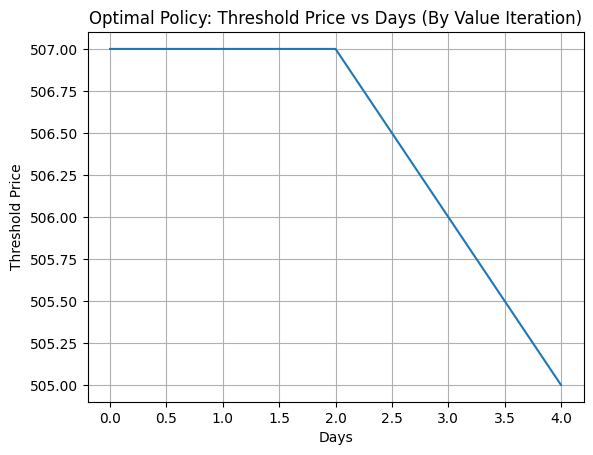

In [353]:
V = value_iteration()

In [354]:
regrets=[]
for i in range(0,len(start_states)):
    regrets.append(V[start_states[i]] - reward_arr[i])

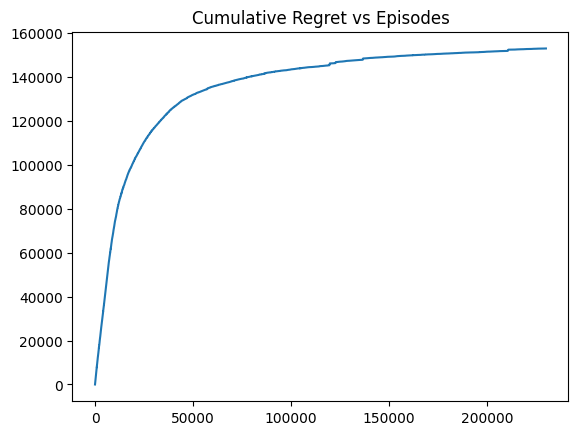

In [355]:
arr_tot = []
for i in range(len(regrets)):
    if(i==0):
        arr_tot.append(regrets[i])
    else:
        arr_tot.append(arr_tot[-1]+regrets[i])
plt.plot(arr_tot)
plt.title("Cumulative Regret vs Episodes")
plt.show()

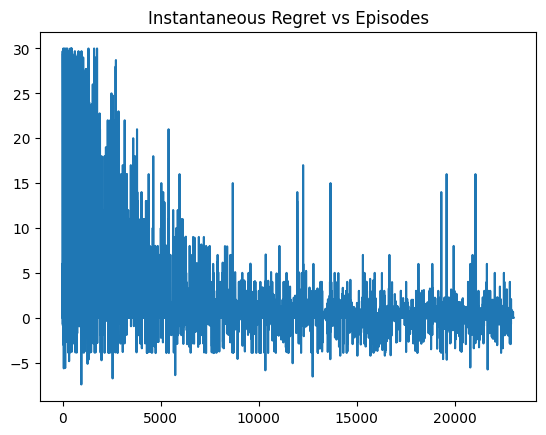

In [356]:
plt.plot(regrets[::10])
plt.title("Instantaneous Regret vs Episodes")
plt.show()